# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [1]:
## DATA DICTIONARY

In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("assets/dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


In [3]:
data["html_ratio"].head()

0    0.245831
1    0.203490
2    0.226402
3    0.265656
4    0.228887
Name: html_ratio, dtype: float64

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [4]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

> ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
<font color=red>They already have is news or is front page news we could build a logit model that would classify things as evergreen or not. The lower the common link ratio, more likely to be ever green. Evergreen sites are going to have a lower ratio. Also take an idea if there are more images then its more evergreen. So something with more tags is less likely to be evergreen</font>
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

### Common Link Ratio, MP WORK

In [5]:
mpdata = data[["commonlinkratio_1","commonlinkratio_2","commonlinkratio_3","commonlinkratio_4","label"]]
mpdata=mpdata.groupby("label", as_index=True)
mpdata.describe()

commonlinkratio_1  commonlinkratio_2  commonlinkratio_3  \
label                                                                  
0     count        3599.000000        3599.000000        3599.000000   
      mean            0.450840           0.201499           0.081618   
      std             0.206289           0.146120           0.088381   
      min             0.000000           0.000000           0.000000   
      25%             0.315789           0.087912           0.013730   
      50%             0.467626           0.190476           0.056962   
      75%             0.600000           0.286921           0.122127   
      max             1.000000           1.000000           0.719086   
1     count        3796.000000        3796.000000        3796.000000   
      mean            0.484718           0.226008           0.101965   
      std             0.198722           0.146354           0.101689   
      min             0.000000           0.000000           0.000000   
      25%             0.361873           0.121212           0.029851   
      50%             0.494047           0.211111           0.079523   
      75%             0.629799           0.312000           0.142402   
      max             0.991453           0.982906           0.980392   

             commonlinkratio_4  
label                           
0     count        3599.000000  
      mean            0.043261  
      std             0.065548  
      min             0.000000  
      25%             0.000000  
      50%             0.018605  
      75%             0.059524  
      max             0.626866  
1     count        3796.000000  
      mean            0.054952  
      std             0.078342  
      min             0.000000  
      25%             0.000000  
      50%             0.026049  
      75%             0.071909  
      max             0.980392

In [6]:
from sklearn import linear_model
comm = linear_model.LogisticRegression()
comm1Model = comm.fit(data[["commonlinkratio_1"]],data["label"])
resultscomm1 = pd.DataFrame(comm1Model.predict_proba(data[["commonlinkratio_1"]]))
resultscomm1 = resultscomm1.join(data["label"])

In [7]:
resultscomm1["ratio"] = data["commonlinkratio_1"]
resultscomm1.columns=["no","yes","label","ratio"]

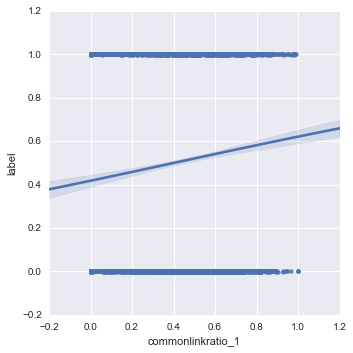

In [8]:
sns.lmplot(x="commonlinkratio_1",y="label",data=data, logistic=True, y_jitter=.001)

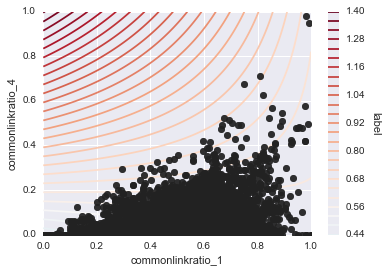

In [9]:
sns.interactplot(x1="commonlinkratio_1",x2="commonlinkratio_4",y="label", data=data)

> ### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

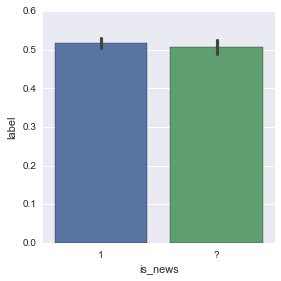

In [10]:
sns.factorplot(x="is_news",y="label",data=data, kind="bar")

In [11]:
data["is_news"].values

array(['1', '1', '1', ..., '?', '1', '?'], dtype=object)

> ### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

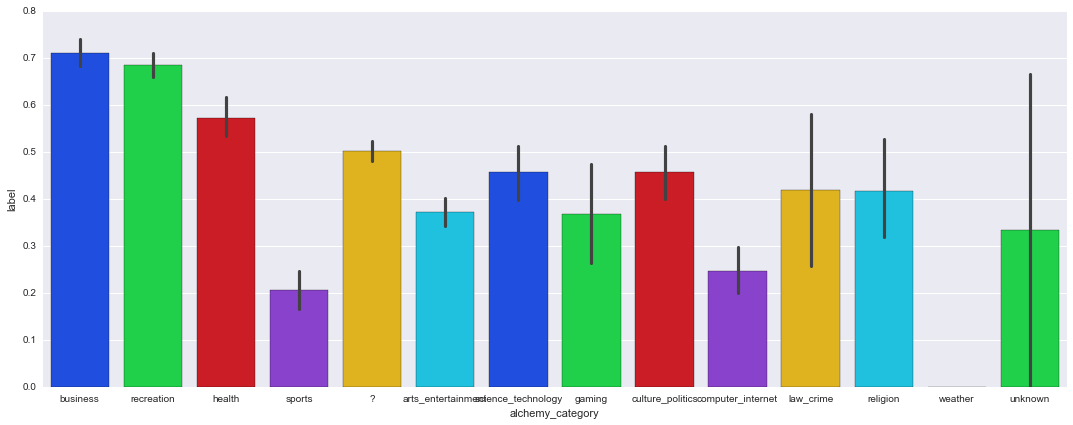

In [12]:
alchemy = data[["alchemy_category","label"]]
sns.factorplot("alchemy_category","label",data=alchemy,kind="bar",palette="bright",size=6,aspect=2.5)


> ### Exercise: 5. How many articles are there per category?

In [13]:
alchemy.groupby("alchemy_category").count()

,label
alchemy_category,
?,2342
arts_entertainment,941
business,880
computer_internet,296
culture_politics,343
gaming,76
health,506
law_crime,31
recreation,1229


> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [14]:
data["recipe"] = data["title"].str.contains("recipe")

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = data[['image_ratio', 'is_news', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [74]:
from sklearn.cross_validation import cross_val_score
cross_score = cross_val_score(model, X, y, cv=10, scoring="roc_auc")


In [75]:
cross_score = pd.DataFrame(cross_score,columns=["Score"])
print cross_score
score = cross_score.mean()
print score

      Score
0  0.579949
1  0.562324
2  0.555420
3  0.587163
4  0.576267
5  0.602289
6  0.580497
7  0.570898
8  0.547207
9  0.584558
Score    0.574657
dtype: float64


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [81]:
model_few = DecisionTreeClassifier(
                max_depth = 10,
                min_samples_leaf = 20,
                criterion="entropy")

model_few.fit(X, y)
build_tree_image(model)

In [86]:
cross_score_few = cross_val_score(model_few, X, y, cv=10, scoring="roc_auc")

In [87]:
cross_score_few = pd.DataFrame(cross_score_few,columns=["Score"])
print cross_score_few
score = cross_score_few.mean()
print score

      Score
0  0.626206
1  0.607538
2  0.608326
3  0.632496
4  0.580067
5  0.640404
6  0.591235
7  0.604935
8  0.608661
9  0.599246
Score    0.609911
dtype: float64


 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [105]:
data["is_news"][data["is_news"]=="?"] = 0

/Users/MP/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [125]:
from sklearn.ensemble import RandomForestClassifier

def make_model(est,feat,depth):
    model_demo = RandomForestClassifier(n_estimators = est, criterion='gini',max_features=feat,max_depth=depth)
    Z = data[['image_ratio', 'html_ratio', 'numberOfLinks','spelling_errors_ratio','is_news','label']].dropna()
    y = Z['label']
    Z.drop('label', axis=1, inplace=True)

    model_demo.fit(Z, y)

    cross_score_demo = cross_val_score(model_demo, Z, y, cv=10, scoring="roc_auc")

    cross_score_demo = pd.DataFrame(cross_score_demo,columns=["Score"])
    print cross_score_demo
    score = cross_score_demo.mean()
    print score

In [129]:
make_model(200,3,10)

      Score
0  0.616422
1  0.624072
2  0.610333
3  0.632672
4  0.601999
5  0.678889
6  0.634609
7  0.627932
8  0.644005
9  0.627865
Score    0.62988
dtype: float64
      Score
0  0.628549
1  0.647573
2  0.627891
3  0.632774
4  0.599532
5  0.667047
6  0.642920
7  0.636672
8  0.646262
9  0.616025
Score    0.634525
dtype: float64
      Score
0  0.631630
1  0.653735
2  0.627931
3  0.641875
4  0.592368
5  0.670446
6  0.638456
7  0.645544
8  0.655079
9  0.631232
Score    0.63883
dtype: float64
      Score
0  0.630037
1  0.652317
2  0.626674
3  0.642007
4  0.613841
5  0.670614
6  0.643807
7  0.647405
8  0.654170
9  0.632246
Score    0.641312
dtype: float64
      Score
0  0.636667
1  0.647961
2  0.630088
3  0.644985
4  0.604740
5  0.673838
6  0.647178
7  0.646687
8  0.657117
9  0.629005
Score    0.641827
dtype: float64


### Demo: Extracting importance of features

In [132]:
features = X.columns
feature_importances = model_demo.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

ValueError: arrays must all be same length

 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [ ]:
# ... #

##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [ ]:
# ... #